In [236]:
import torch
import pykeen
print(torch.__version__)
print(pykeen.version.VERSION)


2.9.1
1.11.1


In [237]:
import json

with open("../../items.json", "r", encoding="utf-8") as f:
    data = json.load(f)

dota_items = data.get("dota_items", {})
neutral_items = data.get("neutral_items", {})

print(len(dota_items))
print(len(neutral_items))

all_items = {}
all_items.update(dota_items)
all_items.update(neutral_items)

len(all_items)


254
62


316

In [238]:
def item_id(name): 
    return f"Item:{name}"

def ability_id(name): 
    return f"Ability:{name}"

def effect_id(name): 
    return f"Effect:{name}"

def role_id(name): 
    return f"Role:{name}"

def tier_id(t): 
    return f"Tier:{t}"

def stat_id(name, bucket): 
    return f"Stat:{name}_{bucket}"


In [239]:
def bucketize(value, bins):
    for low, high in bins:
        if low <= value < high:
            return f"{low}_{high}"
    return f"{bins[-1][0]}_plus"


In [ ]:
# bucketing bins
COST_BINS = (500, 1000, 1500, 2000, 3000, 4000, 5000, 6000)
MANA_COST_BINS = (50, 100, 200)
COOLDOWN_BINS = (10, 30, 60)
BUFF_BINS = (10, 50, 100)
STAT_BINS = (10, 30, 60)

def get_bucket(value, bins):
    for i, bin_edge in enumerate(bins):
        if value < bin_edge:
            return f"{bins[i-1]}_{bin_edge}" if i > 0 else f"0_{bin_edge}"
    return f"{bins[-1]}_plus"

triples = []

# 1. Item -> Role
for name, item in all_items.items():
    for role in item.get("roles", []):
        triples.append((item_id(name), "has_role", role_id(role)))
        # triples.append((role_id(role), "role_of", item_id(name)))

# 2. Ability -> Effect / AbilityType / Stats (+ bucketing)
for item in all_items.values():
    for ability in item.get("abilities", []):
        ability_name = ability["name"].replace(" ", "_").replace("'", "")

        # Ability -> Effect
        for effect in ability.get("effects", []):
            triples.append((ability_id(ability_name), "has_effect", effect_id(effect)))
            triples.append((effect_id(effect), "effect_of", ability_id(ability_name)))

        # Ability -> AbilityType
        ability_type = ability.get("ability_type")
        if ability_type:
            triples.append((ability_id(ability_name), "has_ability_type", f"AbilityType:{ability_type}"))

        # Ability -> Stats
        stats = ability.get("stats", {}).get("additional_stats", {})
        for stat_name, stat_value in stats.items():
            try:
                val = float(stat_value.strip('%'))
                bucket = get_bucket(val, STAT_BINS)
                triples.append((ability_id(ability_name), f"has_stat_{stat_name}", f"StatBucket:{bucket}"))
            except:
                pass

        # Ability -> Cooldown / ManaCost
        cd = ability.get("cooldown")
        if cd is not None:
            bucket = get_bucket(cd, COOLDOWN_BINS)
            triples.append((ability_id(ability_name), "has_cooldown", f"CooldownBucket:{bucket}"))

        mc = ability.get("mana_cost")
        if mc is not None:
            bucket = get_bucket(mc, MANA_COST_BINS)
            triples.append((ability_id(ability_name), "has_mana_cost", f"ManaBucket:{bucket}"))

# 3. Item -> Buffs
for name, item in all_items.items():
    buffs = item.get("buffs", {})
    for buff_name, val in buffs.items():
        if val is not None:
            bucket = get_bucket(val, BUFF_BINS)
            triples.append((item_id(name), f"has_buff_{buff_name}", f"BuffBucket:{bucket}"))

# 4. Item -> CostBucket
for name, item in all_items.items():
    if "cost" in item:
        bucket = get_bucket(item["cost"], COST_BINS)
        triples.append((item_id(name), "has_cost", f"CostBucket:{bucket}"))

# 5. NeutralItem -> Tier
for name, item in neutral_items.items():
    if "tier" in item:
        triples.append((item_id(name), "has_tier", tier_id(item["tier"])))


In [241]:
import pandas as pd

df_triples = pd.DataFrame(triples, columns=["head", "relation", "tail"])
print(df_triples.head())

print("Triples:", len(df_triples))
print("Entities:", len(set(df_triples["head"]) | set(df_triples["tail"])))
print("Relations:", df_triples["relation"].nunique())

                 head  relation          tail
0  Item:Abyssal Blade  has_role  Role:offense
1  Item:Abyssal Blade  has_role  Role:control
2      Item:Aeon Disk  has_role  Role:utility
3      Item:Aeon Disk  has_role  Role:offense
4      Item:Aeon Disk  has_role     Role:mana
Triples: 3014
Entities: 552
Relations: 325


In [242]:
from pykeen.triples import TriplesFactory
import pandas as pd

df_triples = pd.DataFrame(triples, columns=["head", "relation", "tail"])

tf = TriplesFactory.from_labeled_triples(
    triples=df_triples.values
)
print(f"Entities: {len(tf.entity_to_id)}")
print(f"Relations: {len(tf.relation_to_id)}")

Entities: 552
Relations: 325


In [243]:
from pykeen.pipeline import pipeline

# train/test = 80/20
train_tf, test_tf = tf.split([0.8, 0.2], method='coverage', random_state=52)


# train model
result = pipeline(
    training=train_tf,
    testing=test_tf,
    model='DistMult',  # TransE | ComplEx | DistMult
    model_kwargs=dict(embedding_dim=100),
    training_kwargs=dict(num_epochs=150, batch_size=128, use_tqdm=True),
)

model = result.model

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1478, 548]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding(
  (regularizer): LpRegularizer()
)
/Users/lavrent/Library/Caches/pypoetry/virtualenvs/kg-proj-yaD34q_T-py3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Training epochs on cpu: 100%|██████████| 150/150 [00:23<00:00,  6.32epoch/s, loss=0.433, prev_loss=0.421]
Evaluating on cpu:   0%|          | 0.00/548 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|██████

In [244]:
# metrics
metrics = result.metric_results.to_dict()

realistic = metrics['both']['realistic']

print("MR:", realistic['arithmetic_mean_rank'])
print("MRR:", realistic['adjusted_inverse_harmonic_mean_rank'])
print("Hits@1:", realistic['hits_at_1'])
print("Hits@3:", realistic['hits_at_3'])
print("Hits@10:", realistic['hits_at_10'])


MR: 27.1268253326416
MRR: 0.4254491905027476
Hits@1: 0.3239051094890511
Hits@3: 0.4936131386861314
Hits@10: 0.6186131386861314


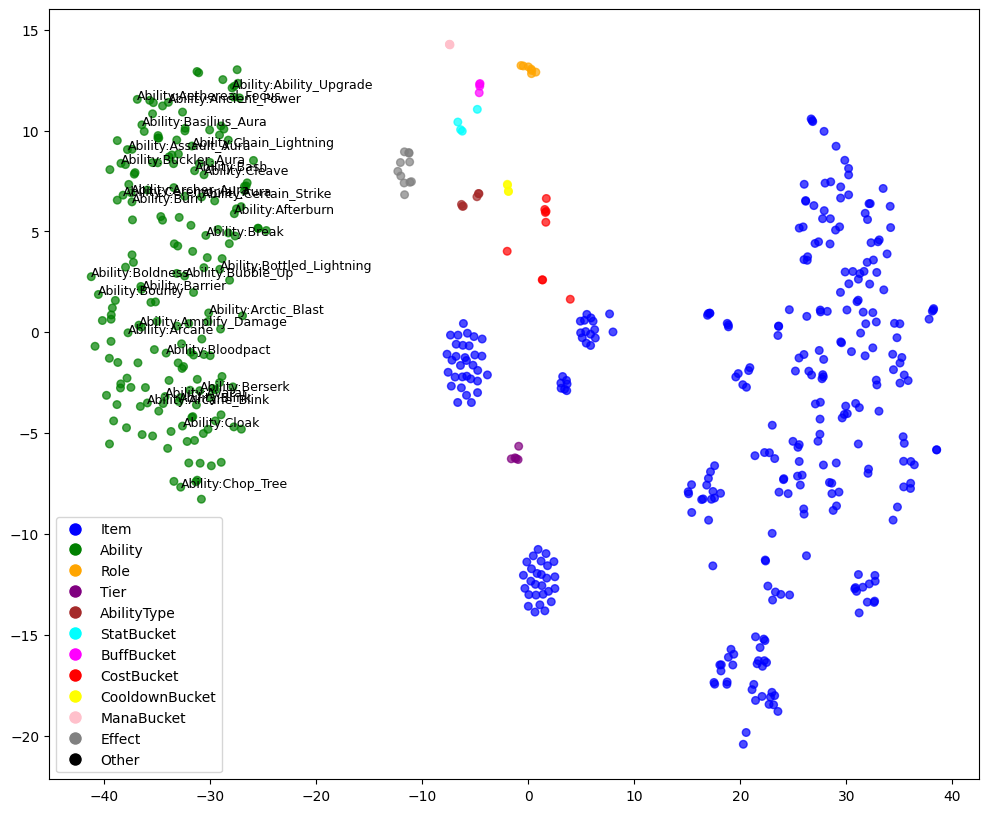

In [255]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

entity_embeddings = model.entity_representations[0](indices=None).detach().cpu().numpy()
entity_labels = list(result.training.entity_to_id.keys())

def get_entity_type(s):
    label, _ = s.split(':', 1)
    if "Bucket" in label:
        if "Stat" in label:
            return "StatBucket"
        elif "Buff" in label:
            return "BuffBucket"
        elif "Cost" in label:
            return "CostBucket"
        elif "Cooldown" in label:
            return "CooldownBucket"
        elif "Mana" in label:
            return "ManaBucket"
        else:
            return "OtherBucket"
    elif label.startswith("AbilityType"):
        return "AbilityType"
    elif label.startswith("AbilityEffect") or label == "Effect":
        return "Effect"
    elif label.startswith("Role") or label == "ItemRole" or label == "Role":
        return "Role"
    elif label == "Item":
        return "Item"
    elif label == "Ability":
        return "Ability"
    elif label == "Tier":
        return "Tier"
    else:
        print(f'warning: unknown entity {s}')
        return "Other"

entity_types = [get_entity_type(l) for l in entity_labels]

type_to_color = {
    "Item": "blue",
    "Ability": "green",
    "Role": "orange",
    "Tier": "purple",
    "AbilityType": "brown",
    "StatBucket": "cyan",
    "BuffBucket": "magenta",
    "CostBucket": "red",
    "CooldownBucket": "yellow",
    "ManaBucket": "pink",
    "Effect": "gray",
    "Other": "black"
}

colors = [type_to_color.get(t, "black") for t in entity_types]

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
entity_2d = tsne.fit_transform(entity_embeddings)

plt.figure(figsize=(12,10))
plt.scatter(entity_2d[:,0], entity_2d[:,1], c=colors, alpha=0.7, s=30)


for i, label in enumerate(entity_labels[:30]):
    plt.text(entity_2d[i,0], entity_2d[i,1], label, fontsize=9)

# legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=10) 
                   for k,v in type_to_color.items()]
plt.legend(handles=legend_elements, loc='best')

plt.show()
